In [1]:
'''
Overview
The following notebook outlines the process utilized to build a 'segmentation' model for the marketing department.
The dependent variable is whether a customer purchased a product (y=1). or not (y=0). 
The implemented model will help the marketing department decide which customers receive an advertisement 
    for the product. 
'''

"\nOverview\nThe following notebook outlines the process utilized to build a 'segmentation' model for the marketing department.\nThe dependent variable is whether a customer purchased a product (y=1). or not (y=0). \nThe implemented model will help the marketing department decide which customers receive an advertisement \n    for the product. \n"

In [2]:
# Reads In Necessary Libraries

# Loads Data Visualization Library
import bokeh

import collections as ccc
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns
import statsmodels.api as sm
import sys
import uvicorn

from collections import Counter

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [3]:
def display_imported_python_libraries():
    print(f'python version {sys.version}')
    print(f'bokeh version {bokeh.__version__}')
    print(f'numpy version {np.__version__}')
    print(f'matplotlib version {matplotlib.__version__}')
    print(f'pandas version {pd.__version__}')
    print(f'seaborn version {sns.__version__}')
    print('statsmodels version ' + '0.13.2')
    print('sklern version ' + '1.1.1' + '\n')

In [4]:
def display_data_info(training_data):

    #Desribes the target variable
    print(Counter(training_data.y))

    # Provides an overview of the data types
    print(f'object dtype: {training_data.columns[training_data.dtypes == "object"].tolist()}')
    print(f'int64 dtype: {training_data.columns[training_data.dtypes == "int"].tolist()}')
    print('The rest of the columns have float64 dtypes. \n')

In [5]:
# Investigate Object Columns
def investigate_object(df):
    """
    This function prints the unique categories of all the object dtype columns.
    It prints '...' if there are more than 13 unique categories.
    """
    col_obj = df.columns[df.dtypes == 'object']

    for i in range(len(col_obj)):
        if len(df[col_obj[i]].unique()) > 13:
            print(col_obj[i]+":", "Unique Values:", np.append(df[col_obj[i]].unique()[:13], "..."))
        else:
            print(col_obj[i]+":", "Unique Values:", df[col_obj[i]].unique())
    
    del col_obj
    
    print('\n')

In [6]:
# Feature Engineering

def training_data_feature_selection(training_data):

    train_val = training_data.copy(deep = True)

    # 1. Fixes the money and percentage formatting 
    train_val['x12'] = train_val['x12'].str.replace('$','')
    train_val['x12'] = train_val['x12'].str.replace(',','')
    train_val['x12'] = train_val['x12'].str.replace(')','')
    train_val['x12'] = train_val['x12'].str.replace('(','-')
    train_val['x12'] = train_val['x12'].astype(float)
    train_val['x63'] = train_val['x63'].str.replace('%','')
    train_val['x63'] = train_val['x63'].astype(float)

    # 2. Creates the training, validation and testing datasets
    x_train, x_val, y_train, y_val = train_test_split(train_val.drop(columns = ['y']), 
                                                      train_val['y'], 
                                                      test_size = 0.1, 
                                                      random_state = 13)

    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 4000, random_state = 13)

    # 3. Smashes the sets back together
    train = pd.concat([x_train, y_train], axis = 1, sort = False).reset_index(drop = True)
    val = pd.concat([x_val, y_val], axis = 1, sort = False).reset_index(drop = True)
    test = pd.concat([x_test, y_test], axis = 1, sort = False).reset_index(drop = True)

    # 4. With mean imputation from Train set
    imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
    imputer = imputer.fit(train.drop(columns = ['y', 'x5', 'x31',  'x81' ,'x82']))
    
    train_imputed = pd.DataFrame(imputer.transform(train.drop(columns = ['y', 'x5', 'x31',  'x81' ,'x82'])), 
                                 columns = train.drop(columns = ['y', 'x5', 'x31', 'x81', 'x82']).columns)
    
    std_scaler = StandardScaler()
    std_scaler = std_scaler.fit(train_imputed)
    
    train_imputed_std = pd.DataFrame(std_scaler.transform(train_imputed), 
                                     columns = train_imputed.columns)

    # 5. Creates dummies
    dumb5 = pd.get_dummies(train['x5'], 
                           drop_first = True, 
                           prefix = 'x5', 
                           prefix_sep = '_', 
                           dummy_na = True)
    
    train_imputed_std = pd.concat([train_imputed_std, dumb5], axis = 1, sort = False)

    dumb31 = pd.get_dummies(train['x31'], 
                            drop_first = True, 
                            prefix = 'x31', 
                            prefix_sep = '_', 
                            dummy_na = True)
    
    train_imputed_std = pd.concat([train_imputed_std, dumb31], axis = 1, sort = False)

    dumb81 = pd.get_dummies(train['x81'], 
                            drop_first = True, 
                            prefix = 'x81', 
                            prefix_sep = '_', 
                            dummy_na = True)
    
    train_imputed_std = pd.concat([train_imputed_std, dumb81], axis = 1, sort = False)

    dumb82 = pd.get_dummies(train['x82'], 
                            drop_first = True, 
                            prefix = 'x82', 
                            prefix_sep = '_', 
                            dummy_na = True)
    
    train_imputed_std = pd.concat([train_imputed_std, dumb82], axis = 1, sort = False)
    train_imputed_std = pd.concat([train_imputed_std, train['y']], axis = 1, sort = False)

    del dumb5, dumb31, dumb81, dumb82
    
    return train, val, test, imputer, train_imputed, std_scaler, train_imputed_std

In [7]:
def display_feature_selection_info(imputer, train_imputed):

    # Displays the imputer statistics
    #imputer.statistics_
    
    # Displays the variance
    train_imputed.var()

In [8]:
'''
Visualizing the Correlations
As part of the exploratory analysis, we want to look at a heatmap 
    to see if there are any high pairwise correlations.  If we see 
    a few number of variables correlated with the target, then we will 
    use an L2 penalty. 
If we see a lot of variables correlated with y then we will use an L2 penalty.
'''

def visualize_correlations(train_imputed_std):
    sns.set(style = 'white')

    corr = train_imputed_std.corr()

    plt.figure(figsize = (12,12))
    sns.set(font_scale = 1)
    sns.heatmap(data = corr,
                center = 0,
                cmap = sns.diverging_palette(220, 10, as_cmap = True), 
                square = True, linewidth = 0.5)

In [9]:
'''
Initial Feature Selection
Looking at the correlation map from above, we can see there are very few variables 
    associated with the dependent variable.  Thus, we will use an L1 penalty to for 
    feature selection. 
Interestingly enough, we see a that some variables have heavy correlation amongst themselves. 
'''

def initial_feature_selection(train_imputed_std):
    exploratory_LR = LogisticRegression(penalty = 'l1', 
                                        fit_intercept = False, 
                                        solver = 'liblinear')
    
    exploratory_LR.fit(train_imputed_std.drop(columns = ['y']), 
                       train_imputed_std['y'])
    
    exploratory_results = pd.DataFrame(train_imputed_std.drop(columns = ['y']).columns).rename(columns = {0:'name'})
    
    exploratory_results['coefs'] = exploratory_LR.coef_[0]
    
    exploratory_results['coefs_squared'] = exploratory_results['coefs']**2
    
    var_reduced = exploratory_results.nlargest(25,'coefs_squared')
    
    return var_reduced

In [10]:
'''
Preliminary Model

Starts off with the train set
The L1 process creates biased parameter estimates.  
As a result, we will build a final model without biased estimators. 
'''
def generate_preliminary_model(var_reduced, train_imputed_std):
    variables = var_reduced['name'].to_list()
    logit = sm.Logit(train_imputed_std['y'], train_imputed_std[variables])
    
    # Fits the model
    result = logit.fit()
    print(result.summary())
    
    return result, variables

In [11]:
# Prepares the validation dataset
def prepare_validation_dataset(simple_imputer, std_scaler, training_data, train_imputed, validation_data):
    val_imputed = pd.DataFrame(simple_imputer.transform(
                                   validation_data.drop(columns = ['y', 'x5', 'x31', 'x81' ,'x82'])), 
                               columns = training_data.drop(columns = ['y','x5', 'x31', 'x81', 'x82']).columns)

    val_imputed_std = pd.DataFrame(std_scaler.transform(val_imputed), 
                                   columns = train_imputed.columns)

    dumb5 = pd.get_dummies(validation_data['x5'], 
                           drop_first = True, 
                           prefix = 'x5', 
                           prefix_sep = '_', 
                           dummy_na = True)

    val_imputed_std = pd.concat([val_imputed_std, dumb5], axis = 1, sort = False)

    dumb31 = pd.get_dummies(validation_data['x31'], 
                            drop_first = True, 
                            prefix = 'x31', 
                            prefix_sep = '_', 
                            dummy_na = True)

    val_imputed_std = pd.concat([val_imputed_std, dumb31], axis = 1, sort = False)

    dumb81 = pd.get_dummies(validation_data['x81'], 
                            drop_first = True, 
                            prefix = 'x81', 
                            prefix_sep = '_', 
                            dummy_na = True)
    val_imputed_std = pd.concat([val_imputed_std, dumb81], axis = 1, sort = False)

    dumb82 = pd.get_dummies(validation_data['x82'], 
                            drop_first = True, 
                            prefix = 'x82', 
                            prefix_sep = '_', 
                            dummy_na = True)

    val_imputed_std = pd.concat([val_imputed_std, dumb82], axis = 1, sort = False)
    val_imputed_std = pd.concat([val_imputed_std, validation_data['y']], axis = 1, sort = False)

    return val_imputed_std

In [12]:
# Prepares the testing dataset
def prepare_testing_dataset(simple_imputer, std_scaler, training_data, train_imputed, testing_data):
    test_imputed = pd.DataFrame(simple_imputer.transform(
                                    testing_data.drop(columns = ['y', 'x5', 'x31', 'x81' ,'x82'])), 
                                columns = training_data.drop(columns = ['y','x5', 'x31', 'x81', 'x82']).columns)
    
    test_imputed_std = pd.DataFrame(std_scaler.transform(test_imputed), 
                                    columns = train_imputed.columns)

    dumb5 = pd.get_dummies(testing_data['x5'], 
                           drop_first = True, 
                           prefix = 'x5', 
                           prefix_sep = '_', 
                           dummy_na = True)
    
    test_imputed_std = pd.concat([test_imputed_std, dumb5], axis = 1, sort=False)

    dumb31 = pd.get_dummies(testing_data['x31'], 
                            drop_first = True, 
                            prefix = 'x31', 
                            prefix_sep = '_', 
                            dummy_na = True)
    
    test_imputed_std = pd.concat([test_imputed_std, dumb31], axis = 1, sort = False)

    dumb81 = pd.get_dummies(testing_data['x81'], 
                            drop_first = True, 
                            prefix = 'x81', 
                            prefix_sep = '_', 
                            dummy_na = True)
    
    test_imputed_std = pd.concat([test_imputed_std, dumb81], axis = 1, sort = False)

    dumb82 = pd.get_dummies(testing_data['x82'], 
                            drop_first = True, 
                            prefix = 'x82', 
                            prefix_sep = '_', 
                            dummy_na = True)
    
    test_imputed_std = pd.concat([test_imputed_std, dumb82], axis = 1, sort = False)
    test_imputed_std = pd.concat([test_imputed_std, testing_data['y']], axis = 1, sort = False)
    
    return test_imputed_std

In [13]:
def generate_preliminary_model_outcomes(variables, 
                                        preliminary_model, 
                                        train_imputed_std, 
                                        val_imputed_std, 
                                        test_imputed_std):

    Outcomes_train = pd.DataFrame(
        preliminary_model.predict(train_imputed_std[variables])).rename(columns = {0:'probs'})
    Outcomes_train['y'] = train_imputed_std['y']

    Outcomes_val = pd.DataFrame(
        preliminary_model.predict(val_imputed_std[variables])).rename(columns = {0:'probs'})
    Outcomes_val['y'] = val_imputed_std['y']

    Outcomes_test = pd.DataFrame(
        preliminary_model.predict(test_imputed_std[variables])).rename(columns = {0:'probs'})
    Outcomes_test['y'] = test_imputed_std['y']

    print('The C-Statistics is ', roc_auc_score(Outcomes_train['y'], Outcomes_train['probs']))
    print('The C-Statistics is ', roc_auc_score(Outcomes_val['y'], Outcomes_val['probs']))
    print('The C-Statistics is ', roc_auc_score(Outcomes_test['y'], Outcomes_test['probs']))

    Outcomes_train['prob_bin'] = pd.qcut(Outcomes_train['probs'], q = 20)

    Outcomes_train.groupby(['prob_bin'])['y'].sum()
    
    return Outcomes_train, Outcomes_val, Outcomes_test

In [14]:
'''
Finalizing the Model
In the code above, we identified that the model generalized well; 
the AUC was similar for each of the partitions of the training data.  
Moving forward, we want to 
    1. refit the model using all of the training data
    2. check the coefficients against the preliminary model
    3. assess the lift and ask for a cutoff from the business partner.
'''
def generate_final_model(train_imputed_std, val_imputed_std, test_imputed_std, var_reduced):
    train_and_val = pd.concat([train_imputed_std, val_imputed_std])
    all_train = pd.concat([train_and_val, test_imputed_std])
    variables = var_reduced['name'].to_list()
    final_logit = sm.Logit(all_train['y'], all_train[variables])

    # Fits the model
    final_result = final_logit.fit()

    print(final_result.summary())
    print('\n')
    
    return final_result

In [15]:
def generate_final_model_outcomes(variables, train_imputed_std, val_imputed_std, test_imputed_std, final_model):
    train_and_val = pd.concat([train_imputed_std, val_imputed_std])
    all_train = pd.concat([train_and_val, test_imputed_std])
    
    Outcomes_train_final = pd.DataFrame(final_model.predict(all_train[variables])).rename(columns = {0:'probs'})
    Outcomes_train_final['y'] = all_train['y']
    
    print('The C-Statistics is ',roc_auc_score(Outcomes_train_final['y'], Outcomes_train_final['probs']))
    
    Outcomes_train_final['prob_bin'] = pd.qcut(Outcomes_train_final['probs'], q = 20)
    
    Outcomes_train_final.groupby(['prob_bin'])['y'].sum()
    
    return Outcomes_train_final

In [16]:
def main():
    
    display_imported_python_libraries()
    
    # Imports the training and testing data
    raw_train = pd.read_csv('exercise_26_train.csv')
    
    display_data_info(raw_train)
    
    investigate_object(raw_train)
    
    train, val, test, imputer, train_imputed, std_scaler, train_imputed_std = (
        training_data_feature_selection(raw_train))
    
    display_feature_selection_info(imputer, train_imputed)
    
    visualize_correlations(train_imputed_std)
    
    var_reduced = initial_feature_selection(train_imputed_std)
    
    print(var_reduced['name'].to_list())
    
    preliminary_model, variables = generate_preliminary_model(var_reduced, 
                                                   train_imputed_std)
    
    val_imputed_std = prepare_validation_dataset(imputer, 
                                                 std_scaler, 
                                                 train, 
                                                 train_imputed, 
                                                 val)
    
    test_imputed_std = prepare_testing_dataset(imputer, 
                                               std_scaler, 
                                               train, 
                                               train_imputed, 
                                               test)
    
    prlmn_outcm_train, prlmn_outcm_val, prlmn_outcm_test = (
        generate_preliminary_model_outcomes(variables,
                                            preliminary_model, 
                                            train_imputed_std, 
                                            val_imputed_std, 
                                            test_imputed_std))
    
    final_model = generate_final_model(train_imputed_std, 
                                       val_imputed_std, 
                                       test_imputed_std, 
                                       var_reduced)
    
    final_outcm_train = generate_final_model_outcomes(variables, 
                                                      train_imputed_std, 
                                                      val_imputed_std, 
                                                      test_imputed_std, 
                                                      final_model)
    
    pickle.dump(std_scaler, open('../models/glm_standard_scalar.pickle', 'wb'))
    pickle.dump(imputer, open('../models/glm_simple_imputer.pickle', 'wb'))
    final_model.save('../models/glm_final_model.pickle')

python version 3.10.4 | packaged by conda-forge | (main, Mar 24 2022, 17:39:37) [Clang 12.0.1 ]
bokeh version 2.4.3
numpy version 1.23.3
matplotlib version 3.5.2
pandas version 1.4.2
seaborn version 0.11.2
statsmodels version 0.13.2
sklern version 1.1.1

Counter({0: 20096, 1: 19904})
object dtype: ['x5', 'x12', 'x31', 'x63', 'x81', 'x82']
int64 dtype: ['y']
The rest of the columns have float64 dtypes. 

x5: Unique Values: ['tuesday' 'saturday' 'thursday' 'sunday' 'wednesday' 'monday' 'friday']
x12: Unique Values: ['$6,882.34 ' '$5,647.81 ' '($5,032.58)' '($1,920.03)' '($5,859.08)'
 '$8,535.02 ' '$66.55 ' '$2,421.58 ' '($2,586.99)' '($4,324.44)'
 '($8,015.98)' '$2,669.04 ' '$1,729.51 ' '...']
x31: Unique Values: ['germany' 'asia' 'america' 'japan' nan]
x63: Unique Values: ['62.59%' '3.11%' '28.07%' '33.49%' '88.73%' '11.05%' '89.23%' '69.48%'
 '35.15%' '67.12%' '90.90%' '60.46%' '68.56%' '...']
x81: Unique Values: ['April' 'December' 'May' 'November' 'March' 'June' 'July' 'October'
 'Ja

/var/folders/tc/dtjmhvc55bd1swsb_wk1cnbr0000gn/T/ipykernel_84058/1751185040.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  train_val['x12'] = train_val['x12'].str.replace('$','')
/var/folders/tc/dtjmhvc55bd1swsb_wk1cnbr0000gn/T/ipykernel_84058/1751185040.py:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  train_val['x12'] = train_val['x12'].str.replace(')','')
/var/folders/tc/dtjmhvc55bd1swsb_wk1cnbr0000gn/T/ipykernel_84058/1751185040.py:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  train_val['x12'] = train_val

['x5_saturday', 'x81_July', 'x81_December', 'x31_japan', 'x81_October', 'x5_sunday', 'x31_asia', 'x81_February', 'x91', 'x81_May', 'x5_monday', 'x81_September', 'x81_March', 'x53', 'x81_November', 'x44', 'x81_June', 'x12', 'x5_tuesday', 'x81_August', 'x81_January', 'x62', 'x31_germany', 'x58', 'x56']
Optimization terminated successfully.
         Current function value: 0.536381
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                32000
Model:                          Logit   Df Residuals:                    31975
Method:                           MLE   Df Model:                           24
Date:                Tue, 13 Sep 2022   Pseudo R-squ.:                  0.2262
Time:                        11:02:12   Log-Likelihood:                -17164.
converged:                       True   LL-Null:                       -22181.
Covariance Type:            nonrobust   LLR

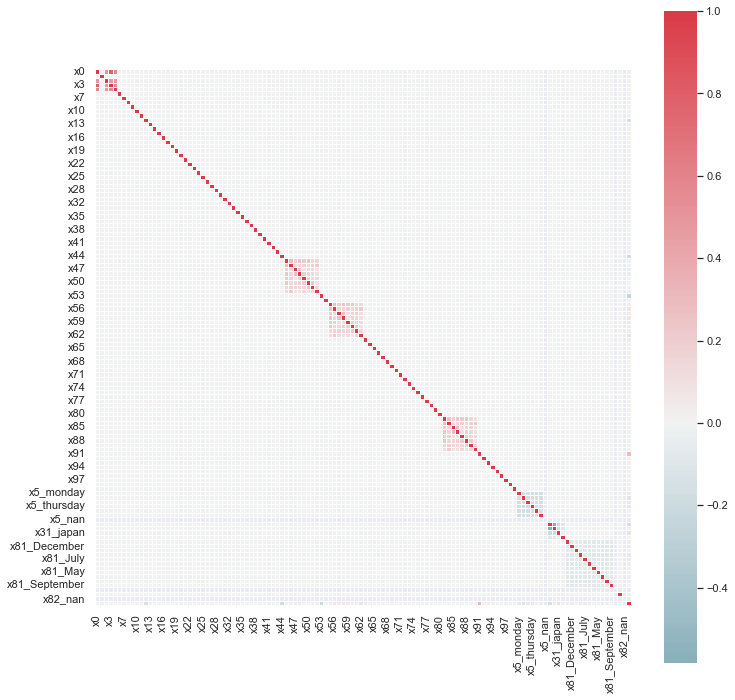

In [17]:
main()

## Debrief
In the final discussion with the business partner, the partner was thrilled with the rank-order ability of the model.  Based on a combination of capacity and accuracy, the partner would like to classify any observation that would fall in the top 5 bins as an event; for simplicity we will say the cutoff is at the 75th percentile.  For the API, please return the predicted outcome (variable name is business_outcome), predicted probability (variable name is phat), and all model inputs; the variables should be returned in alphabetical order in the API return.